# Libraries

In [1]:
import pandas as pd
import numpy as np

import importlib as imp

import matplotlib.pyplot as plt

# Read data

In [2]:
data = pd.read_csv('./data/udemy_courses.csv')
# display(data.head())

# Exploring data

In [3]:
from source import helper
from source import pipeline
imp.reload(helper);
imp.reload(pipeline);

## Initial findings

__Findings__:
* The `course_id` field is type of int64. However, the maximum value of this field is equal to 1282064. As a result we can change its type into int32 for saving memory space.
* The `is_paid` field might be a Boolean field, which contains only True and False. As a result, we can convert its type into int8 for saving memory space.
* Normally, the `price` field is type of int or float. However, in this case, it is type of object. Therefore, we need to have some investigations here.
* Three counting fields such as `num_subscribers`, `num_reviews`, and `num_lectures` are type of int. However, their maximum value is different from each other. As a result, we need to change the memory size here.
    * `num_subscribers`: int64 -> int32
    * `num_reviews`: int64 -> int16
    * `num_lectures`: int64 -> int 16
* The `level` field might be a categorical variable. We will need to find whether or not it contains unusual data points such as empty string, non-readable string, etc.
* Normally, the `content_duration` is type of int or float. However, in this case, its type is object. As a result, we need some investigations to transform the data.
* For now, the meaningful data of the `published_timestamp` field might be year. This is because we can use this information to search for which are popular technical topics in a particular year.
* The `subject` field might be a categorical variable. We will need to find whether or not it contains unusual data points such as empty string, non-readable string, etc. Also, this data can be use for the evaluation.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   course_id            3683 non-null   int64 
 1   course_title         3683 non-null   object
 2   url                  3683 non-null   object
 3   is_paid              3683 non-null   object
 4   price                3683 non-null   object
 5   num_subscribers      3683 non-null   int64 
 6   num_reviews          3683 non-null   int64 
 7   num_lectures         3683 non-null   int64 
 8   level                3683 non-null   object
 9   content_duration     3683 non-null   object
 10  published_timestamp  3683 non-null   object
 11  subject              3683 non-null   object
dtypes: int64(4), object(8)
memory usage: 345.4+ KB


In [5]:
data[['num_subscribers', 'num_reviews', 'num_lectures']].describe()

,num_subscribers,num_reviews,num_lectures
count,3683.000000,3683.000000,3683.000000
mean,3193.371165,156.448004,40.062178
std,9498.231406,935.078241,50.366788
min,0.000000,0.000000,0.000000
25%,110.000000,4.000000,15.000000
50%,911.000000,18.000000,25.000000
75%,2537.500000,67.000000,45.000000
max,268923.000000,27445.000000,779.000000


__Findings__:
* There is not NaN or missing value in the initial data.

In [6]:
helper.check_nan(data)

course_id              0
course_title           0
url                    0
is_paid                0
price                  0
num_subscribers        0
num_reviews            0
num_lectures           0
level                  0
content_duration       0
published_timestamp    0
subject                0
dtype: int64

## Going deeper into each feature

__course_id feature__:
* There are duplicate courses in the data. Therefore, courses that exist more than 2 times need to be merged.
* The type of the feature needs to be converted into np.int32

In [7]:
# # Pre-data
# print("Pre-data:")
# display(helper.describe_freq(data, 'course_id', 2))

# # Process
# data = helper.merge_duplicate_row(data, 'course_id')
# data['course_id'] = data['course_id'].astype(np.int32)

# # Post-data
# print("Post-data:")
# display(helper.describe_freq(data, 'course_id', 2))

__is_paid feature__:
* There is unusual value, it needs to be fill by np.nan.

In [8]:
# # Pre-data
# print("Pre-data:")
# display(helper.describe_freq(data, 'is_paid', 1))

# # Process
# data['is_paid'] = data['is_paid'].apply(lambda x: x.lower()) \
#                                     .apply(lambda x: helper.convert_bool_to_int(x))
# data.dropna(subset=['is_paid'], inplace=True)
# data['is_paid'] = data['is_paid'].astype(np.int8)

# # Post-data
# print("Post-data:")
# display(helper.describe_freq(data, 'is_paid', 1))
# print("NaN values: {}".format(helper.check_nan(data['is_paid'])))

__course_title feature:__
* Found that courses whose title has length of less than 3 might be multilingual courses. Therefore, those title need to be replaced by the text in the url feature.

__url feature:__
* Found that there are urls that contain multi-words without spacing. 

In [9]:
# print("Title length: 1")
# display(helper.check_text_length(data, 'course_title', 1).head())
# print("Title length: 2")
# display(helper.check_text_length(data, 'course_title', 2).head())

In [10]:
# data = helper.convert_url_to_string(data, 'url')
# print("URL length: 1")
# display(helper.check_text_length(data, 'url', 1).head())

In [11]:
# helper.check_text_length(pipeline.clean_data(data), 'course_title', 2).head()

__price feature:__
* Found that the price feature should be type of integer, but object.
* Found that 'Free' is in the price feature. This should set to be 0

In [12]:
# # Pre-data
# print("Pre-data:")
# display(np.unique(data['price']))

# # Process
# data = helper.convert_free_price(data, 'price')

# # Post-data
# print("Post-data:")
# display(np.unique(data['price']))

__level feature:__
* Found that the level feature contains 4 unique values. These values can be dummied for the further analysis.

In [13]:
# display(np.unique(data['level']))

__content_duration feature:__
* Found that the there are 4 different categories in this feature.
    * '0' indicates there is no course duration. This needs to be removed
    * 'hour', 'hours' or 'mins' indicate the course duration calculated by using the time factor.
    * 'questions' indicates the course duration calculated by using the solved time factor. Assuming that each question can be solved in 2.5 minutes.
* To make the feature has a consistent unit, all observations are converted into hour(s).

In [14]:
# display(np.unique(data['content_duration']))
# display(data[data['content_duration'].isin(['218 questions', '24 questions', '82 questions', '0'])])
# data['content_duration'] = data['content_duration'].apply(lambda duration: helper.convert_duration(duration))
# data['content_duration'] = data['content_duration'].astype(np.float32)
# data.dropna(subset=['content_duration'], inplace=True)

__published_timestamp feature:__
* Found that all of the courses in this dataset were published from 2011 to 2017. This information can be used for further analysis when trying to match the trending topics in each year. 

In [15]:
# display(np.unique(data['published_timestamp'].apply(lambda time: time.split("-")[0])))
# data = helper.convert_published_time(data, 'published_timestamp')

__subject feature:__
* Found that the subject feature contains 4 unique values. These values can be dummied for the further analysis.

In [16]:
# display(np.unique(data['subject']))

## Run pipeline

In [17]:
data = pipeline.clean_data(data)

# Finding the definition of popularity

On average, we can see that most of the courses in dataset are low price courses. In addition, most of these courses has a low number of subscribers, a low number of lectures, and a low number of reviews. In order to define the meaning of popularity in this senario, we need to dig into courses that have a high number of subscribers as well as a high number of reviews.

In [18]:
data[['price', 'num_subscribers', 'num_reviews', 'num_lectures']].describe()

,price,num_subscribers,num_reviews,num_lectures
count,3676.000000,3676.000000,3676.000000,3676.000000
mean,66.063656,3187.668934,156.205114,40.096572
std,61.014309,9483.366476,935.682615,50.407036
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,111.000000,4.000000,15.000000
50%,45.000000,912.000000,18.000000,25.000000
75%,95.000000,2544.000000,67.000000,46.000000
max,200.000000,268923.000000,27445.000000,779.000000


In [19]:
display(helper.describe_crosstab(data, 'num_subscribers', 'price'))
display(helper.describe_crosstab(data, 'num_lectures', 'price'))
display(helper.describe_crosstab(data, 'num_reviews', 'price'))

,low_price,high_price
low_num_subscribers,2044,862
high_num_subscribers,439,331


,low_price,high_price
low_num_lectures,1967,639
high_num_lectures,516,554


,low_price,high_price
low_num_reviews,2218,952
high_num_reviews,265,241


On average, courses that have a high number of subscribers are priced roughly $75 and have roughly 12270 subscribers as well as rouhgly 622 reviews. In addition, within 770 courses, there are 220 free courses. Furthermore, there are 194 courses that have more than 12271 subscribers. In these 194 courses, there are 92 courses that have more than 622 reviews.

In [20]:
high_sub = helper.get_rows_by_mean(data, 'num_subscribers', option="more")
display(high_sub[['price', 'num_subscribers', 'num_reviews']].describe())
print("Number of free courses: {}".format(len(high_sub[high_sub['price'] == 0])))
display(helper.describe_crosstab(high_sub, 'num_subscribers', 'price'))
display(helper.describe_crosstab(high_sub, 'num_subscribers', 'num_reviews'))

,price,num_subscribers,num_reviews
count,770.000000,770.000000,770.000000
mean,75.006494,12270.790909,622.509091
std,74.263396,17961.793251,1973.194626
min,0.000000,3190.000000,0.000000
25%,0.000000,4678.000000,57.000000
50%,50.000000,7017.500000,147.000000
75%,145.000000,12319.250000,432.250000
max,200.000000,268923.000000,27445.000000


Number of free courses: 202


,low_price,high_price
low_num_subscribers,357,219
high_num_subscribers,111,83


,low_num_reviews,high_num_reviews
low_num_subscribers,521,55
high_num_subscribers,102,92


On average, courses that cost less than 75 USD have more subscribers than those that cost more than 75 USD. In addition, courses that have a high number of reviews have more subscribers than those that have a low number of reviews.

In [21]:
# Get the mean of a number of subscribers in the high_sub data
mean_hs_sub =  np.mean(high_sub['num_subscribers'])

# Get the mean price in the high_sub data
mean_hs_price = np.mean(high_sub['price'])

# Get the mean of a number of reviews in the high_sub data
mean_hs_reviews = np.mean(high_sub['num_reviews'])

# Get a total number of subscribers in 2 different segments (in terms of price)
high_sub_low_price = high_sub[(high_sub['num_subscribers'] > mean_hs_sub) & 
                              (high_sub['price'] < mean_hs_price)]['num_subscribers']
high_sub_high_price = high_sub[(high_sub['num_subscribers'] > mean_hs_sub) & 
                               (high_sub['price'] > mean_hs_price)]['num_subscribers']

print("Total subscribers of high_sub_low_price: {}".format(np.sum(high_sub_low_price)))
print("Total subscribers of high_sub_high_price: {}\n".format(np.sum(high_sub_high_price)))

# Get a total number of subscribers in 2 different segments (in terms of reviews)
high_sub_low_reviews = high_sub[(high_sub['num_subscribers'] > mean_hs_sub) & 
                              (high_sub['num_reviews'] < mean_hs_reviews)]['num_subscribers']
high_sub_high_reviews = high_sub[(high_sub['num_subscribers'] > mean_hs_sub) & 
                               (high_sub['num_reviews'] > mean_hs_reviews)]['num_subscribers']

print("Total subscribers of high_sub_low_reviews: {}".format(np.sum(high_sub_low_reviews)))
print("Total subscribers of high_sub_high_reviews: {}".format(np.sum(high_sub_high_reviews)))

Total subscribers of high_sub_low_price: 3495688
Total subscribers of high_sub_high_price: 2357419

Total subscribers of high_sub_low_reviews: 2014723
Total subscribers of high_sub_high_reviews: 3838384


__Conclusion:__

In this dataset, there are three characteristics which are common in most of the popular courses. 
1. Popular courses tend to have more than a high number of subscribers - on average, that is more than 12700 subscribers.
2. Popular courses tend to have a high number of reviews.
3. Popular courses tend to cost lower than the average price.

# Finding popular topics

In this section, we will preprocess the text in the `course_title` into topics which are defined as noun phrases or consecutive nouns in the text. Then, we will do some analytics for finding popular topics. Furthermore, we will find popular topics for each subject.

The diagram below shows the entire process of preprocessing the text as well as the proces of extracting topics from text.

<img src="./images/preprocess_text.png">

In [22]:
data = helper.preprocess_text(data, 'course_title', 'topics')

In [23]:
# Uncommented to observe the transformation of topics
# for title, topics in data[:40:][['course_title', 'topics']].values:
#     print(title)
#     print("--> {}\n".format(topics))

In [24]:
def plot_stat(data, phrase_len, columns, by):
    # Get the cout
    res = helper.get_top_topics(data, columns=columns, phrase_len=phrase_len, top=10, by=by)
    
    x = [val[0] for val in res]
    y = [val[1] for val in res]
    ind = np.arange(len(res))
    width = 0.75

    plt.figure(figsize=(18, 9))
    plt.barh(ind, y, width)
    plt.yticks(ind + width/15, labels=x, fontsize=12)
    for i, v in enumerate(y):
        plt.text(v + 0.5, i - 0.1, str(v), fontsize=13)
    plt.xlabel("Topic frequency", fontsize=16)
    
    title = "Top-10 {}-word(s) topics by ".format(phrase_len)
    if by == "freq":
        title += "topic frequency"
    elif by == "sub":
        title += "subscribers"
    elif by == "reviews":
        title += "reviews"
    plt.title(title, fontsize=16)
    
    plt.show();

## Popular topics in the general view

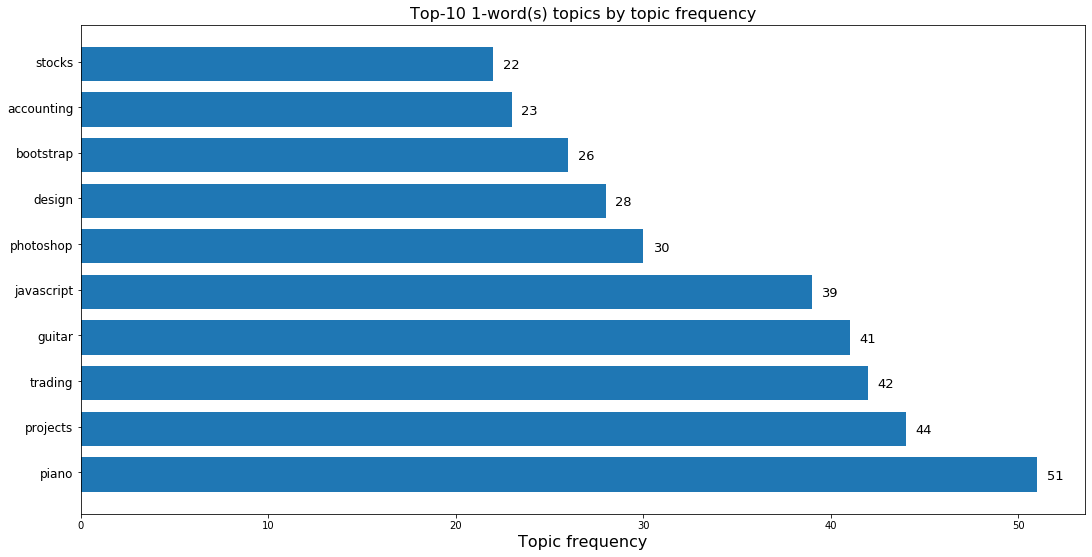

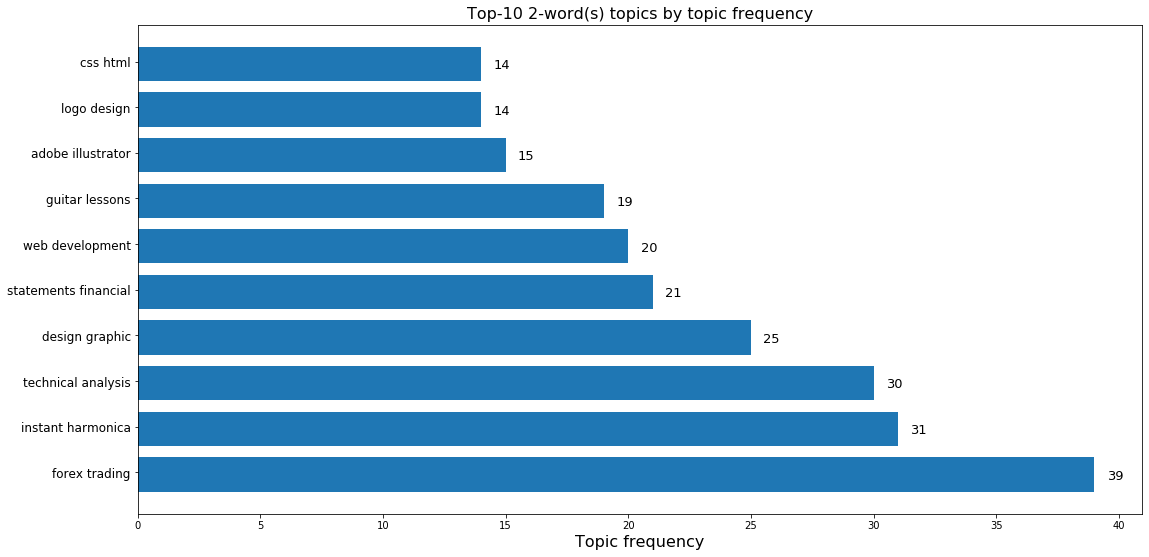

In [25]:
plot_stat(data, 1, columns=["topics"], by='freq')
plot_stat(data, 2, columns=["topics"], by='freq')

With top-10 1-word topics (by frequency), it might be hard to define which topics were taught the most. This is because they varied around 4 main subjects such as business finance, graphic design, musical instruments, and web development.

With top-10 2-word topics (by frequency), we can see that topics related to business finance were taught the most, following by topics related to web development, design, and musical instruments.

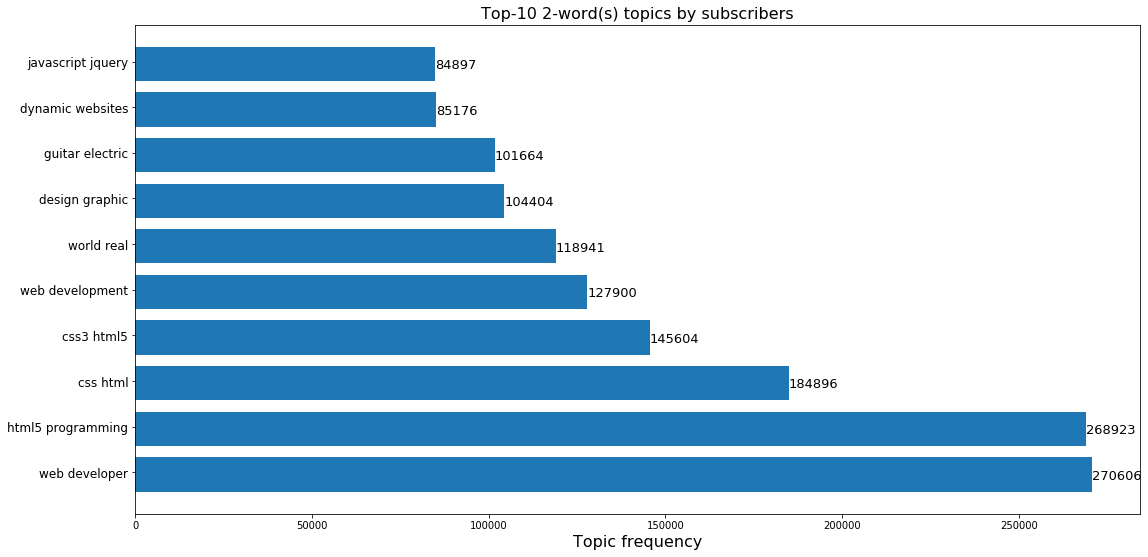

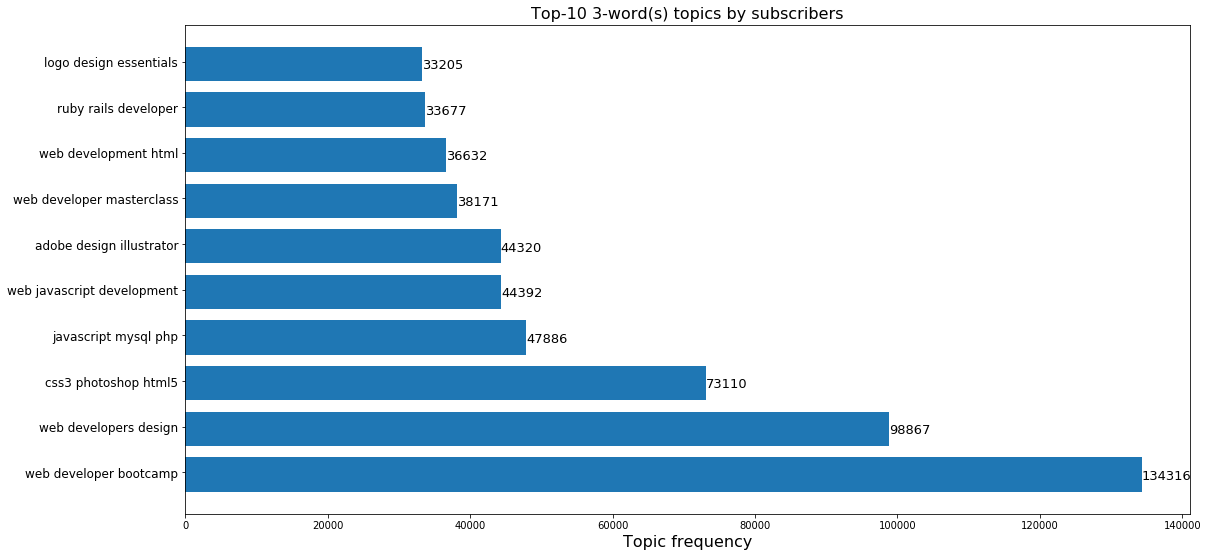

In [26]:
plot_stat(data, 2, columns=["num_subscribers", "topics"], by='sub')
plot_stat(data, 3, columns=["num_subscribers", "topics"], by='sub')

With top-10 2-word topics (by subscribers), we can see that topics related to web development were subscribed the most, following by topics related to design, musical instruments and business finance.

With top-10 3-word topics (by subscribers), we can see that topics related to web development were subscribed the most, following by topics related to design.

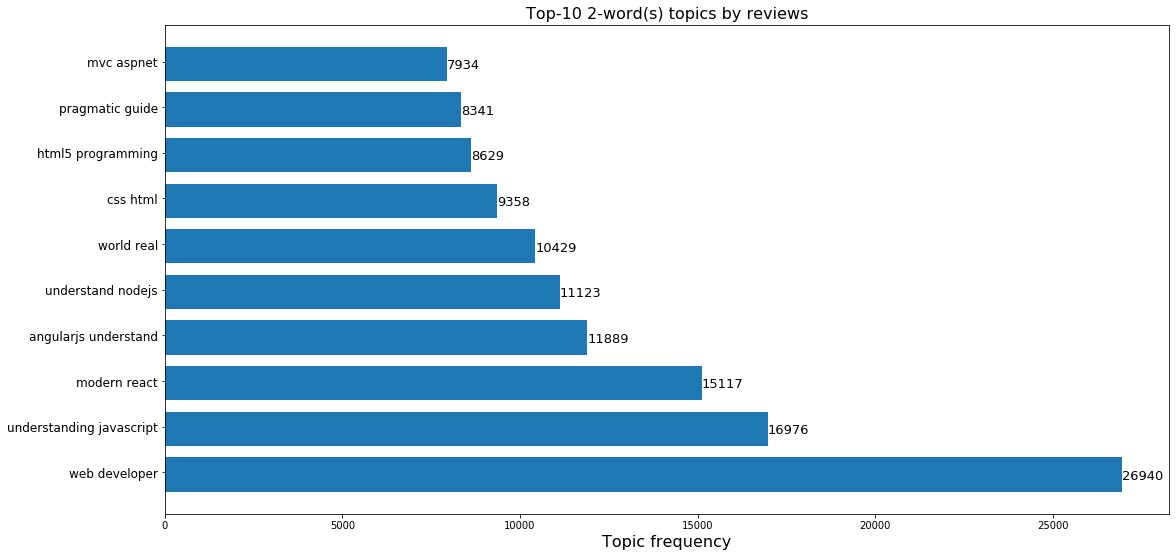

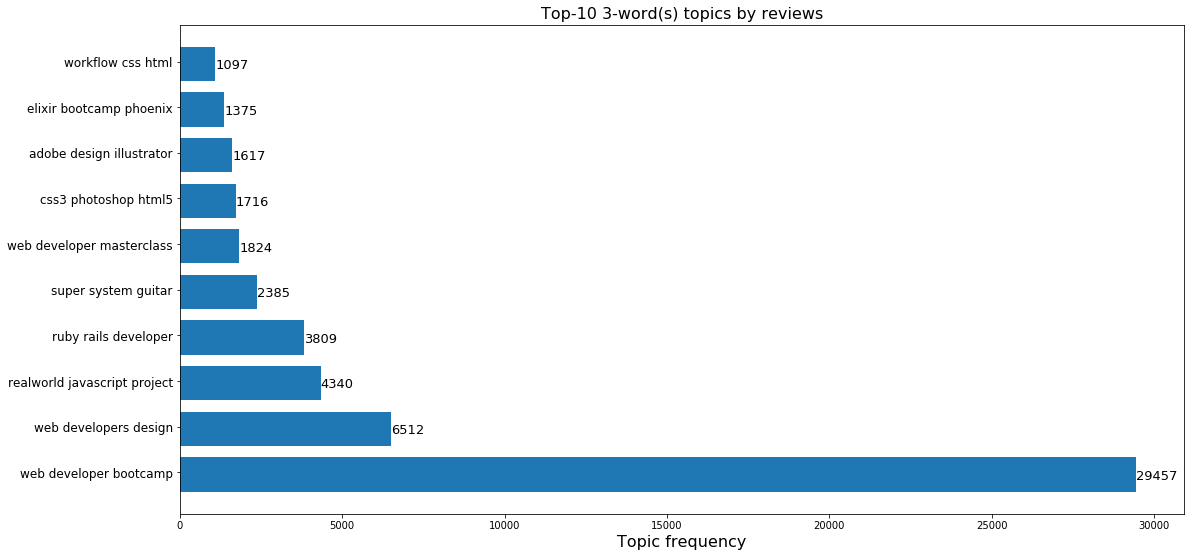

In [27]:
plot_stat(data, 2, columns=["num_reviews", "topics"], by='reviews')
plot_stat(data, 3, columns=["num_reviews", "topics"], by='reviews')

With top-10 2-word topics (by reviews), we can see that topics related to web development were reviewed the most, following by topics related to other subjects.

With top-10 3-word topics (by reviews), we can see that topics related to web development were reviewed the most, following by topics related to design.

## Popular topics for each subject

### Web development

In [28]:
webdev_data = data[data['subject'] == 'Web Development']

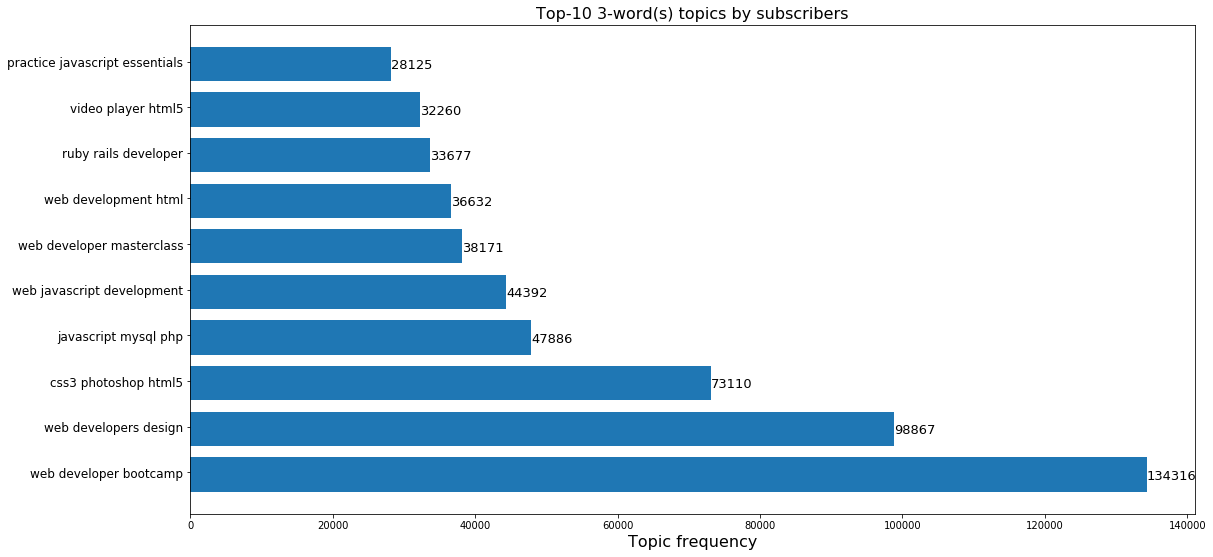

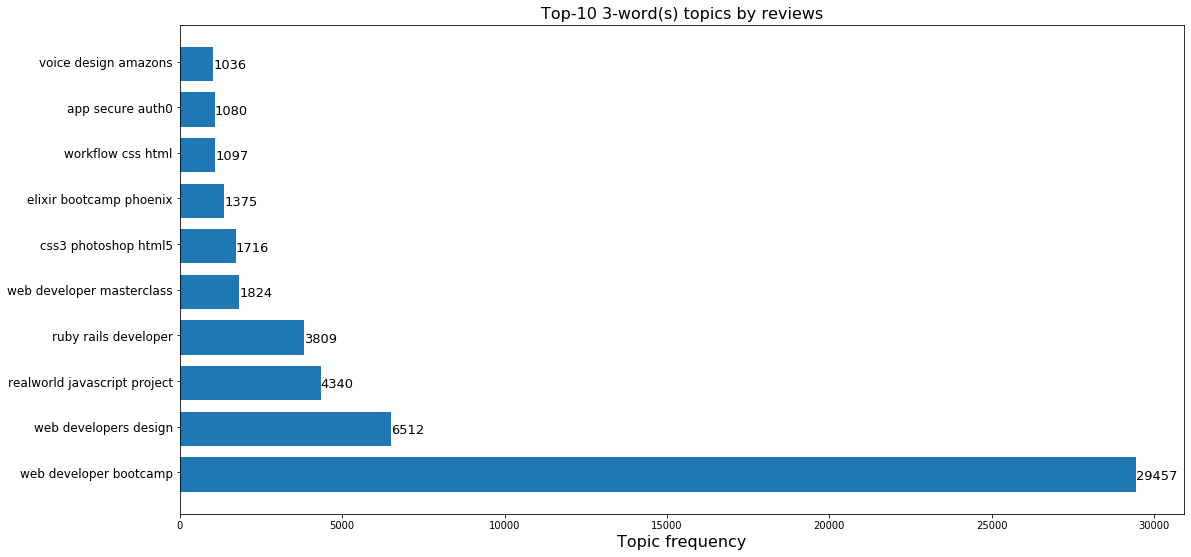

In [29]:
plot_stat(webdev_data, 3, columns=["num_subscribers", "topics"], by='sub')
plot_stat(webdev_data, 3, columns=["num_reviews", "topics"], by='reviews')

From the plotted data, we can see that some fundamental topics of web development such as HTML, CSS, and JavaScript were subscribed and reviewed the most.

### Design

In [30]:
design_data = data[data['subject'] == 'Graphic Design']

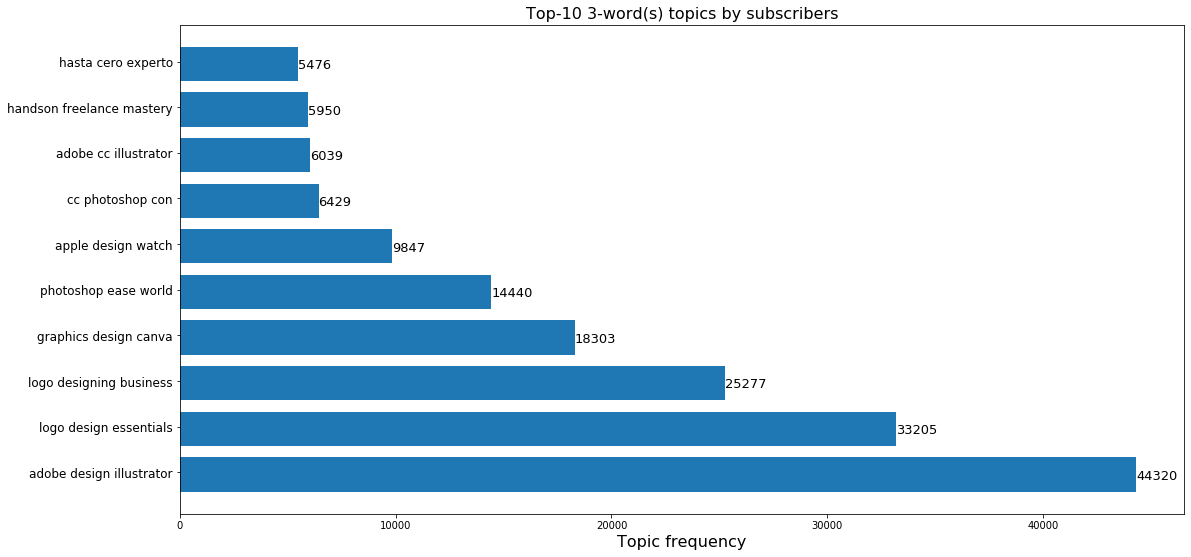

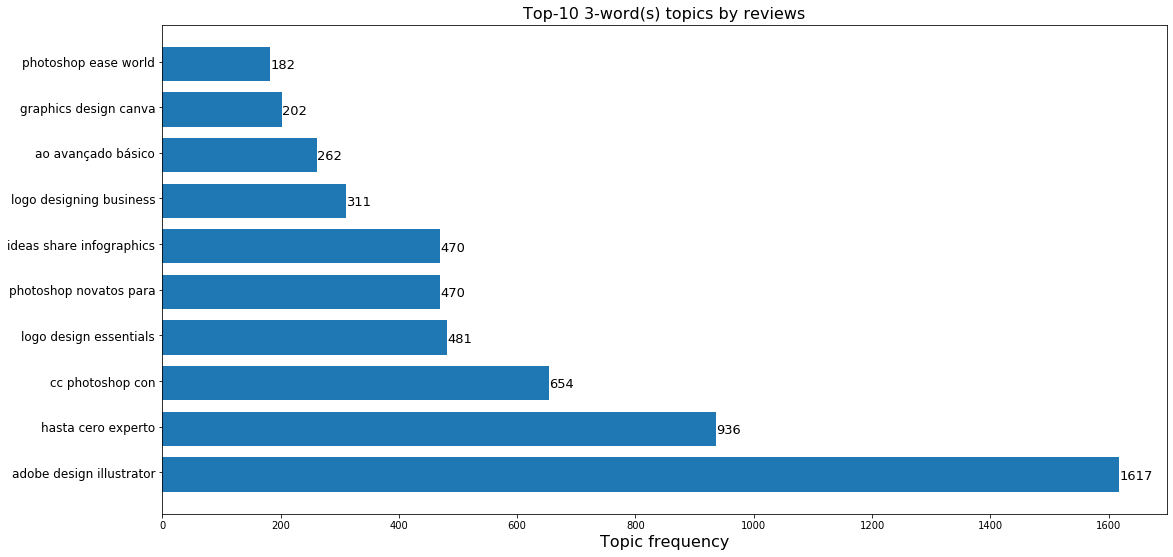

In [31]:
plot_stat(design_data, 3, columns=["num_subscribers", "topics"], by='sub')
plot_stat(design_data, 3, columns=["num_reviews", "topics"], by='reviews')

From the plotted data, we can see that people tended to subscribe and review on courses that are related to some popular design tools such as Adobe Illustrator, Adobe Photoshop and Canva. In addition, designing logo for business was one of the most popular topics.

### Business finance

In [32]:
biz_data = data[data['subject'] == 'Business Finance']

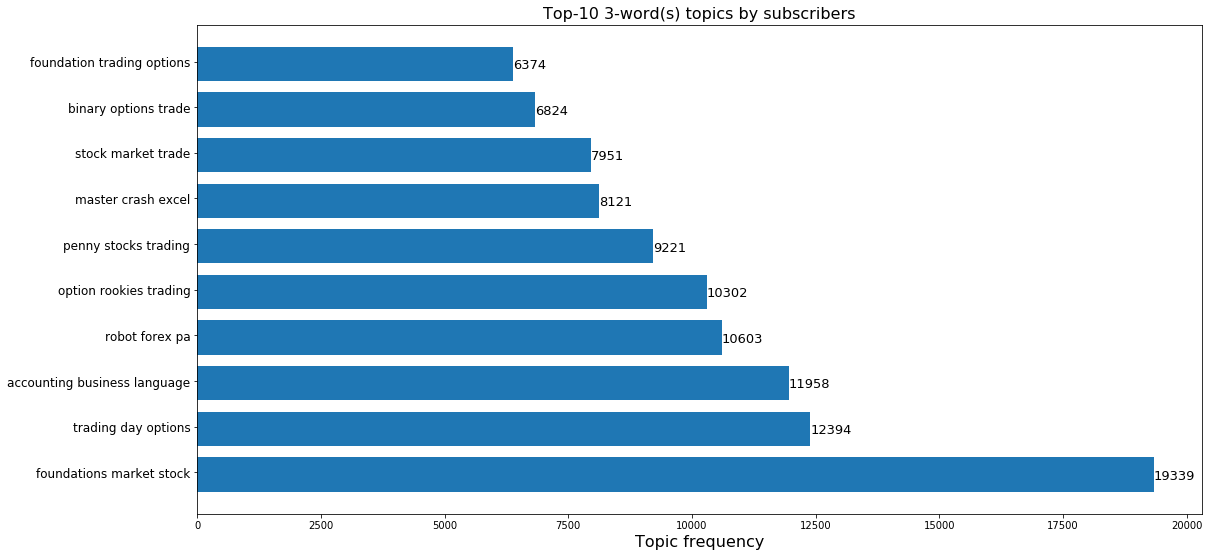

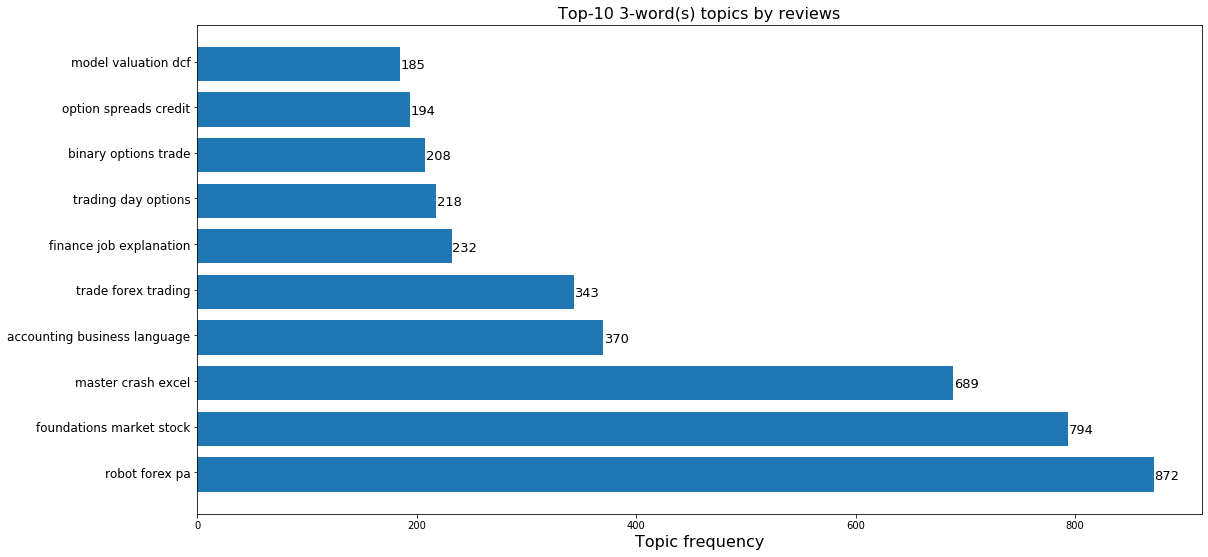

In [33]:
plot_stat(biz_data, 3, columns=["num_subscribers", "topics"], by='sub')
plot_stat(biz_data, 3, columns=["num_reviews", "topics"], by='reviews')

From the plotted data, we can see that options, stocks, and forex are topics that were subscribed and reviewed the most.

### Musical instruments

In [34]:
music_data = data[data['subject'] == 'Musical Instruments']

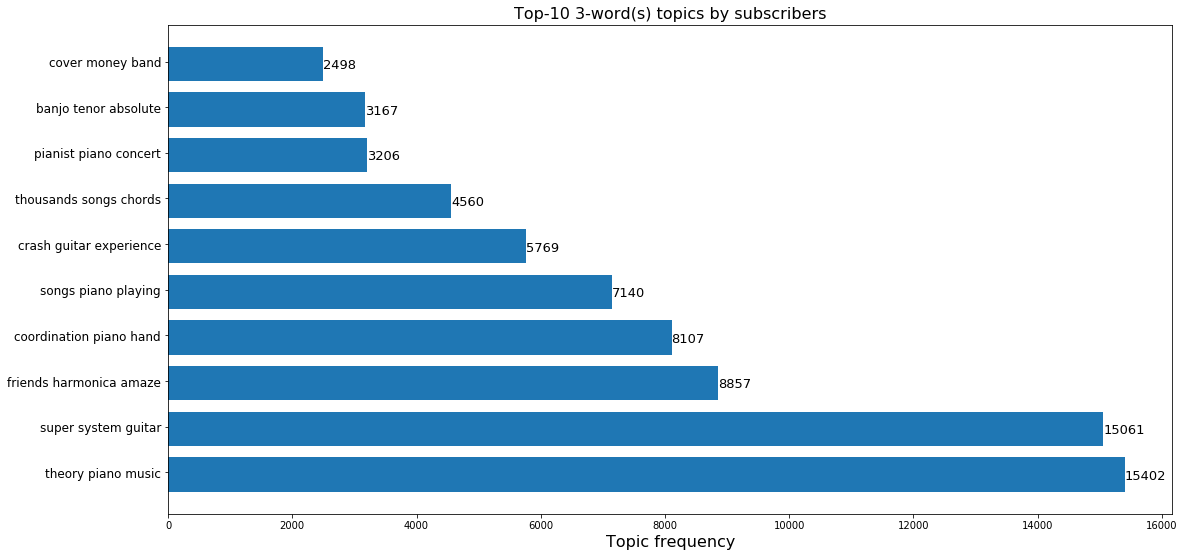

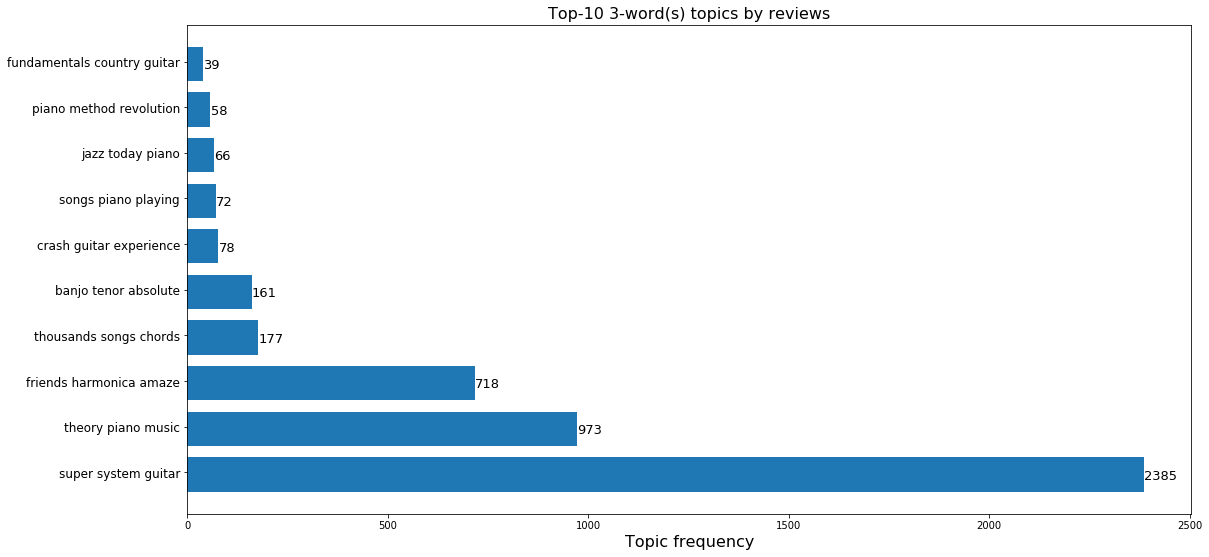

In [35]:
plot_stat(music_data, 3, columns=["num_subscribers", "topics"], by='sub')
plot_stat(music_data, 3, columns=["num_reviews", "topics"], by='reviews')

From the plotted data, we can see that topics that are related to piano or guitar were subscribed and reviewed the most.